# Group 12: Prototypical Networks for Few-shot Learning (J. Snell, K. Swersky, R. S. Zemel, 2017) [2]
Lukas Schießer, Jana Steiner, Polina Tsvilodub

## Introduction

Adavances in machine learning in the realm of computer vision have led to impressive performance of artificial neural networks on tasks like image classification, surpassing the human performance in terms of classification accuracy. However, classical convolutional neural networks require thousands of labeled training examples of each class in order to achieve this performance. Confronted with novel classes in the inference phase, the performance could drastically decrease. 

In contrast, from an early age on humans can perform classification of novel objects given as few examples as two or three representatives of a new class [3]. This discrepancy motivates the recent efforts in the area of so-called few-shot classification - the classifier must perform classification into new classes not presented in the training set given only a small number of examples of each new class. We replicate the prototypical network approach to this problem proposed by [2]. This approach was shown to be quite successful, next to other popular techniques like matching networks [5] and meta-learning [4].

The structure of out project is as follows: We present the theoretical background of the paper, including relevant mathematical formulas and short code chunks implementing them. Then, we replicate the three experiments presented in the paper: the prototypical network for few-shot learning is tested on the omniglot dataset and on the miniImageNet dataset; its performance for zero-shot learning is tested on the CU-Birds dataset. The experimental section includes the longer relevant code chunks training and testing the model. The datasets were downloaded and accessed locally or from Google drive or downloaded from the respective GitHub repositories. The results are discussed at the end of each experiment (we deem this more plausible than coming back to each experiment at the end in a common section).

## Theoretical Background
The main assumption taken in the development of prototypical networks for few-shot classification is that there exists an embedding where examples of a class cluster around a single class representative in the high-dimensional embedding space - the __prototype__ of the respective class. To tackle the task of few-shot classification, such an embedding is learned which allows to compute a prototype of a novel class given only a few examples of this class (only _a few shots_) and to classify examples of these novel categories embedded in the same space as the prototypes in the inference phase. Implicitly, this approach assumes that the class representatives must have some common features which can meaningfully be extracted and represented. 

To approximate the few-shot classification test situation where only a few examples of a novel class are presented, the training procedes on episodes - sampled mini-batches consisting of support and query points. The support points are used for the prototype calculation and the query points are used for testing the embedding (i.e. computing the loss). Hence, prototypical networks learn a non-linear mapping of the support data of a class $k$ into an embedding space where the prototype $c _k$ is computed as the mean of the support set $S _k$:

$\begin{aligned}c _k = \frac{1}{\left|S _k\right|}\sum_{(x_i, y_i)  in  S _k}f _\phi(x _i) \end{aligned}$

```
prototypes = tf.reshape(embedding_output,[NUM_WAY, NUM_SUPPORT, output.shape[-1]])
prototypes = tf.math.reduce_mean(prototypes, axis=1)
```

Then embedded query points are classified by finding the nearest class prototype, i.e. computing the softmax over distances between the embedded query point and the class prototypes, the prototype with the highest probability being the predicted class.

`tf.argmax(tf.nn.log_softmax(-dists, axis=-1), axis=-1)`

The same approach is taken to the zero-shot learning. Here, the class meta-information embedding is learned which serves as the class prototype; the embedded query points are then classified by finding the nearest class prototypes.

An important contribution of the paper is the use of squared Euclidean distance as the distance function between prototypes and query points (as opposed to other popular metrics like cosine similarity).

The authors performed an analysis of the implemented model and concluded that for a distance function that is a regular Bregman divergence (which holds of the chosen squared Euclidean distance) the learning performed by the network is equivalent to performing mixture density estimation on the support set with an exponential family density. The squared Euclidean distance corresponds to a spherical Gaussian density. Therefore, the chosen distance specifies the modeling assumptions about the data distribution in the embedding space depending on the class. Further, the authors show that the probability estimation of a particular class for a query point is equivalent to a linear model, whereas the non-linearity is learned in the embedding function, which makes the prorotypical approach simpler compared to other popular approaches [2].

## Architecture
### Episodes
The training episodes are constructed in order to create a learning situation resembling the inference phase, following [5]. For each episode, a subset of classes from the total set of training classes is sampled to be trained on; the number of sampled classes is the way-number: e.g. for 5-way learning, 5 classes are randomly sampled each episode. However, the authors note that it turns out to be beneficial to train on a higher number of classes than the expected number of classes in the test phase and tuned the number of ways on a held-out validation set. We use their results.
Further, from the data points of this class the support set is randomly sampled. The number of chosen data points (sampled without replacement) corresponds to the shot-number: for example, for 5-shot classification, 5 support points are sampled. Then the query points are randomly sampled from the remaining examples. The number of shots was identical in train and test phases.
  


In [ ]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow.keras import Model
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.layers import Layer
import tensorflow_datasets as tfds
import os
from PIL import Image
import glob

In [ ]:
np.random.seed(2019)
tf.random.set_seed(2019)

In [ ]:
def create_episode(data, num_c, num_s, num_q, w, h, c):
    # sample an n-way subset from the classes
    classes_in_ep = np.random.randint(0, data.shape[0], size=num_c)
    support = np.zeros([num_c, num_s, w, h, c], dtype=np.float32)
    query = np.zeros([num_c, num_q, w, h, c], dtype=np.float32) 
    for i in enumerate(classes_in_ep):
        datapoint_indices = np.random.randint(0, data.shape[0], size=num_s+num_q) # sth like this? 
        support_indices = datapoint_indices[:num_s] # get the images at these indices
        query_indices = datapoint_indices[num_s:] # get the query images 
        for j in enumerate(support_indices):
            support[i[0],j[0]] = data[i[1], j[1]] # somehow get NUM_SUPPORT datapoints corresponding to class 
        for z in enumerate(query_indices):
            query[i[0],z[0]] = data[i[1], z[1]]
    return support, query

### Neural Network
The encoding network consists of four convolutional blocks, each consistsing of:

- a 64-filter 3x3 convolution layer,
- a batch normalization layer,
- a ReLU activation function,
- a 2x2 max-pooling layer.

The input dimensions to the first layer are adjusted to the respective experiments: they are (28,28,1) for the omniglot dataset (grayscale images resized to 28x28) and (84, 84, 3) for the miniImagenet dataset (RGB-images of size 84x84).  

In [ ]:
class PN(Model):
    def __init__(self):
        super(PN,self).__init__()
        self.cnn1 = tf.keras.layers.Convolution2D(filters=64,
                                                  kernel_size=3,
                                                  strides=(1,1),
                                                  padding='same',
                                                  activation=None,
                                                  input_shape=(None,28,28,1)) # omniglot input shape
        self.batchnorm1 = tf.keras.layers.BatchNormalization()
        self.maxpool1 = tf.keras.layers.MaxPool2D((2,2))
        self.cnn2 = tf.keras.layers.Convolution2D(filters=64,
                                                  kernel_size=3,
                                                  strides=(1,1),
                                                  padding='same', 
                                                  activation=None)
        self.batchnorm2 = tf.keras.layers.BatchNormalization()
        self.maxpool2 = tf.keras.layers.MaxPool2D((2,2))
        self.cnn3 = tf.keras.layers.Convolution2D(filters=64,
                                                  kernel_size=3,
                                                  strides=(1,1),
                                                  padding='same',
                                                  activation=None)
        self.batchnorm3 = tf.keras.layers.BatchNormalization()
        self.maxpool3 = tf.keras.layers.MaxPool2D((2,2))
        self.cnn4 = tf.keras.layers.Convolution2D(filters=64,
                                                  kernel_size=3,
                                                  strides=(1,1),
                                                  padding='same',
                                                  activation=None)
        self.batchnorm4 = tf.keras.layers.BatchNormalization()
        self.maxpool4 = tf.keras.layers.MaxPool2D((2,2))
        self.flatten = tf.keras.layers.Flatten()

    def call(self,x,training):
        x = self.cnn1(x)
        x = self.batchnorm1(x,training=training)
        x = tf.nn.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = self.batchnorm2(x,training=training)
        x = tf.nn.relu(x)
        x = self.maxpool2(x)
        x = self.cnn3(x)
        x = self.batchnorm3(x,training=training)
        x = tf.nn.relu(x)
        x = self.maxpool3(x)
        x = self.cnn4(x)
        x = self.batchnorm4(x,training=training)
        x = tf.nn.relu(x)
        x = self.maxpool4(x)
        x = self.flatten(x)
        return x

The models were trained using SGD with Adam, with a learning rate starting at 0.001 and cut in half every 2000 episodes. 

In [ ]:
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps = 2000,
    decay_rate = 0.5,
    staircase=True 
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)



The minimized loss function $J(\phi)$ is the negative probability of the true class of the query point as estimated by calculating the log-softmax over squared Euclidean distances between the query point and each prototype (hence, the loss is a cross entropy loss). Hence, for every prototype $c _k$ and query point $x$ the squared Euclidean distance is calculated:

$\begin{aligned} d(x, c _k) = \left| \left| f _\phi(x) - c _k \right| \right|^2 \end{aligned}$




In [ ]:
def dist(q, p):
    n = q.shape[0]
    m = p.shape[0]
    q = tf.tile(tf.expand_dims(q, 1), [1, m, 1])
    p = tf.tile(tf.expand_dims(p, 0), [n, 1, 1])
    return tf.reduce_sum(tf.math.pow(q - p, 2), 2)

Then probability of each prototype being the true class of the query point is calculated by applying the softmax to the negative distances: 

$\begin{aligned} p _\phi (y = k | x) = \frac{exp(-d(f _\phi(x), c _k ))}{\sum _{k'} exp(-d(f _\phi(x), c _{k'} ))}\end{aligned}$

Then the cross-entropy loss is calculated 

$\begin{aligned} J(\phi) = -log  p _\phi(y = k | x) \end{aligned}$ for the true class $k$.

The loss is calculated by creating a one-hot encoding of the classes of each query point:
```
y = np.tile(np.arange(NUM_WAY)[:, np.newaxis], (1, NUM_QUERY))
y_onehot = tf.cast(tf.one_hot(y, NUM_WAY), tf.float64)
```
and calculating the log-softmax over the negative squared Euclidean distances between the query point and each prototype:

```
log_p_y = tf.nn.log_softmax(-dists, axis=-1)
```

The total loss is then the mean loss over all cross-entropy loss values for all query points in the episode:

```
loss = -(tf.reduce_mean(tf.reshape(tf.reduce_sum(tf.multiply(y_onehot, log_p_y), axis=-1), [-1])))
```

The train and test accuracy is determined by calculating the average number of correctly predicted classes for the query points per episode. For example, for 5 classes with 10 query points each, we check if the predicted class (the class to which highest probability is assigned) for the first query point of the first class matches the true class of the query point. If it does, a 1 is assigned, it it does not, a 0 is assigned; and so forth. Thus, if 10 query point classes out of the total 50 were predicted correctly, this results in an accuracy of $(10 * 1 + 40 * 0) / 50 = 0.2 $. 

## Experiments
### Omniglot
The first experiment we replicated is few-shot classification performed on the Omniglot dataset. The dataset contains 1623 different handwritten characters from 50 different alphabets, there are 20 examples per character as 84x84 grayscale images. The images were resized to 28x28 grayscale images according to the original paper. The data was augmented by rotating each character by multiples of 90° (0°, 90°, 180°, 270°) to increase variation in the dataset, bringing the total of examples per character to 40 [5][2]. We decided to download the dataset manually because that way it is already split in training (*images_background.zip*) and evaluation (*images_evaluation.zip*) data. We structured the data as a 5-dimensional array `[number of classes(characters), number of examples per character, height, width, channel]`. We reproduced the 5-shot classification experiment by training on episodes with 60 classes ("ways"), 5 support points per class (matching the number of support points during testing) and 5 query points per class. For testing we used episodes with 5 classes for 5-way classification, 5 support points per class and the remaining 15 examples per class as query points. [2]


In [ ]:
%%capture
DATADIR='data/omniglot'

! mkdir -p $DATADIR
! wget -O images_background.zip https://github.com/brendenlake/omniglot/blob/master/python/images_background.zip?raw=true
! wget -O images_evaluation.zip https://github.com/brendenlake/omniglot/blob/master/python/images_evaluation.zip?raw=true
! unzip images_background.zip -d $DATADIR
! unzip images_evaluation.zip -d $DATADIR

In [ ]:
cwd = os.getcwd()
listOfFiles = list()
dirpaths = []
for (dirpath, dirnames, filenames) in os.walk(cwd+'/data/omniglot/images_background'):
    dirpaths.append(dirpath)
for dirpath in dirpaths:
    class_images = sorted(glob.glob(os.path.join(dirpath+'/', '*.png')))
    listOfFiles.append(class_images)
listOfFiles = [x for x in listOfFiles if x != []]

In [ ]:
training_data = np.zeros((len(listOfFiles),20,28,28,1))
for i in range(len(listOfFiles)):
    for j in range(20):
        image = Image.open(listOfFiles[i][j]).resize((28, 28))
        image = np.asarray(image)
        image = np.expand_dims(image, -1)
        training_data[i,j,:,:,:] = image

In [ ]:
listOfFiles_test = list()
dirpaths_test = []
for (dirpath, dirnames, filenames) in os.walk(cwd+'/data/omniglot/images_evaluation'):
    dirpaths_test.append(dirpath)
for dirpath in dirpaths_test:
    class_images = sorted(glob.glob(os.path.join(dirpath+'/', '*.png')))
    listOfFiles_test.append(class_images)
listOfFiles_test = [x for x in listOfFiles_test if x != []]

In [ ]:
test_data = np.zeros((len(listOfFiles_test),20,28,28,1))
for i in range(len(listOfFiles_test)):
    for j in range(20):
        image = Image.open(listOfFiles[i][j]).resize((28, 28))
        image = np.asarray(image)
        image = np.expand_dims(image, -1)
        test_data[i,j,:,:,:] = image

In [ ]:
# augment data as described in paper
aug_data = np.zeros((training_data.shape[0]*4,training_data.shape[1],28,28,1))
for i in range(0,aug_data.shape[0],4):
    for j in range(0,aug_data.shape[1]):
        for k in range(4):
            aug_data[i+k,j,:,:,:] = np.rot90(training_data[i//4,j,:,:,:], k=k)

In [ ]:
def create_episode2(data,num_c,num_s,num_q,w,h,c):
    num_ex = 20
    support = np.zeros([num_c, num_s, w, h, c], dtype=np.float32)
    query = np.zeros([num_c, num_q, w, h, c], dtype=np.float32)
    classes_in_ep = np.random.permutation(data.shape[0])[:num_c]

    for i, i_class in enumerate(classes_in_ep):
        selected = np.random.permutation(num_ex)[:num_s + num_q]
        support[i] = data[i_class, selected[:num_s]]
        query[i] = data[i_class, selected[num_s:]]

    return support, query

In [ ]:
tf.keras.backend.clear_session()
NUM_CLASSES = 60
NUM_SUPPORT = 5 # set to 1 for 1-shot classification
NUM_QUERY = 5

# initializing model and optimizer
model = PN()
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps = 2000,
    decay_rate = 0.5,
    staircase=True 
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#begin training loop
w,h,c = 28,28,1
losses = []
accuracies = []
steps = []
step = 0
early_stopping = False
patience = 200
# create training episode
while not early_stopping:
    support, query = create_episode2(aug_data,NUM_CLASSES,NUM_SUPPORT,NUM_QUERY,w,h,c)
    # reshape support episode, so it can be processed by model
    s = tf.reshape(support, [NUM_CLASSES * NUM_SUPPORT, w, h, c])
    # compute embedding of support samples
    with tf.GradientTape() as tape:
        output = model(s,training=True)
        prototypes = tf.reshape(output,[NUM_CLASSES, NUM_SUPPORT, output.shape[-1]])
        # Prototypes are means of NUM_SUPPORT examples
        prototypes = tf.math.reduce_mean(prototypes, axis=1)
        q = tf.reshape(query, [NUM_CLASSES*NUM_QUERY,w,h,c])
        query_output = model(q,training = True)
        # distance here is squared euclidean distance between embedded query samples and prototypes
        dists = dist(query_output, prototypes)
        # reshape distance array to have shape (number of classes, embedded query samples per class, shape of embedding)
        dists = tf.reshape(dists,[NUM_CLASSES,NUM_QUERY,dists.shape[-1]])
        y = np.tile(np.arange(NUM_CLASSES)[:, np.newaxis], (1, NUM_QUERY))
        y_onehot = tf.one_hot(y, NUM_CLASSES)
        log_p_y = tf.nn.log_softmax(-dists, axis=-1)
        # loss computation
        loss = -(tf.reduce_mean(tf.reshape(tf.reduce_sum(tf.multiply(y_onehot, log_p_y), axis=-1), [-1])))
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))
    # computation of accuracies
    log_p_y = tf.reshape(log_p_y, [NUM_CLASSES, NUM_QUERY, -1])
    eq = tf.cast(tf.equal(
                tf.cast(tf.argmax(log_p_y, axis=-1), tf.int32), 
                tf.cast(y, tf.int32)), tf.float32)
    acc = tf.reduce_mean(eq)
    accuracies.append(acc)
    steps.append(step)
    step += 1
    losses.append(loss.numpy())
    if step % 50 == 0 or step == 1:
      print('Episode: ', step, 'Loss: ',  loss.numpy(),'Accuracy: ', acc.numpy())
    # early stopping mechanism with patience set to 200
    if len(losses) > patience and max(losses[-patience:]) == losses[-1]:
      early_stopping = True
print('Number of training steps: ', step)

Episode:  1 Loss:  3.3798218 Accuracy:  0.3
Episode:  50 Loss:  0.4727851 Accuracy:  0.8666667
Episode:  100 Loss:  0.33733523 Accuracy:  0.86
Episode:  150 Loss:  0.29251298 Accuracy:  0.9
Episode:  200 Loss:  0.14776434 Accuracy:  0.94666666
Episode:  250 Loss:  0.18237525 Accuracy:  0.9266667
Episode:  300 Loss:  0.14585681 Accuracy:  0.9533333
Episode:  350 Loss:  0.121609725 Accuracy:  0.96666664
Episode:  400 Loss:  0.09513445 Accuracy:  0.96666664
Episode:  450 Loss:  0.111255646 Accuracy:  0.96666664
Episode:  500 Loss:  0.15696512 Accuracy:  0.95666665
Episode:  550 Loss:  0.09120633 Accuracy:  0.9633333
Episode:  600 Loss:  0.16450357 Accuracy:  0.97
Episode:  650 Loss:  0.1295917 Accuracy:  0.9433333
Episode:  700 Loss:  0.11716039 Accuracy:  0.95666665
Episode:  750 Loss:  0.11072013 Accuracy:  0.9533333
Episode:  800 Loss:  0.07223452 Accuracy:  0.9633333
Episode:  850 Loss:  0.062584355 Accuracy:  0.9766667
Number of training steps:  877


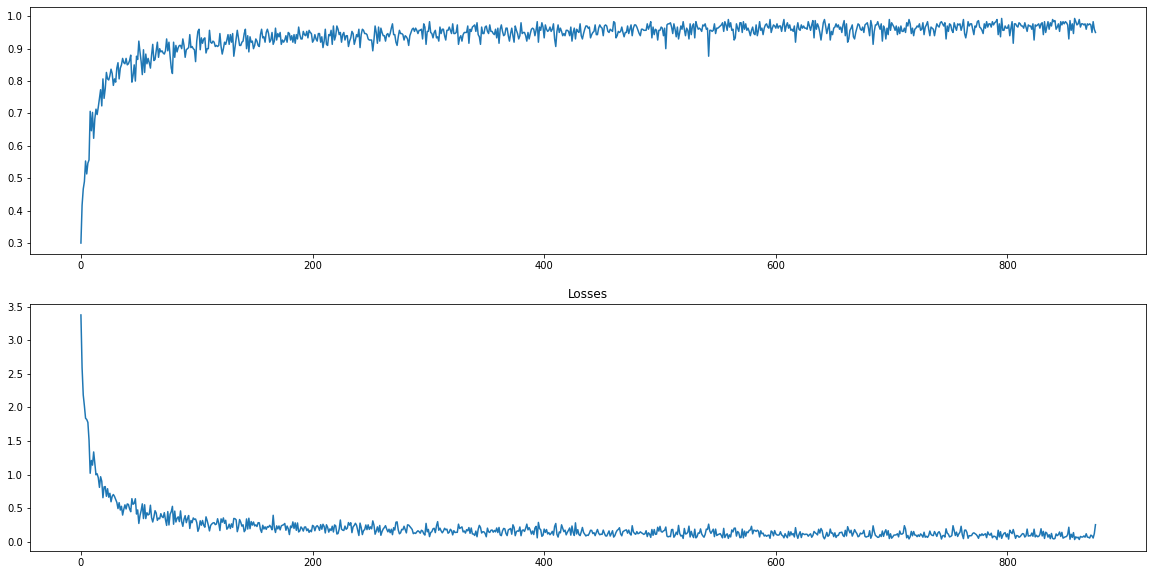

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(steps, accuracies)
plt.subplot(2,1,2)
plt.title('Losses')
plt.plot(steps, losses)
plt.show()

To compute the classification accuracy, we recorded the mean classification accuracy over 1000 randomly generated test episodes according to the specifications from the original paper. 

In [ ]:
TEST_CLASSES = 5 # set to 20 for 20-way classification
TEST_SUPPORT = 5 # set to 1 for 1-shot classification
TEST_QUERY = 15
# begin testing loop
# 1000 testing episodes
test_accuracies = []
steps = []
test_losses = []
for step in range(1000):
    support, query = create_episode2(test_data,TEST_CLASSES,TEST_SUPPORT,TEST_QUERY,w,h,c)
    s = tf.reshape(support,[TEST_CLASSES*TEST_SUPPORT,w,h,c])
    output = model(s,training=False)
    prototypes = tf.reshape(output,[TEST_CLASSES, TEST_SUPPORT, output.shape[-1]])
    # Prototypes are means of NUM_SUPPORT examples
    prototypes = tf.math.reduce_mean(prototypes, axis=1)
    q = tf.reshape(query, [TEST_CLASSES*TEST_QUERY,w,h,c])
    query_output = model(q,training = False)
    # distance here is squared euclidean distance between embedded query samples and prototypes
    dists = dist(query_output, prototypes)
    # according to formula given in Algorithm 1 by paper
    sum_alldist_querypoints = tf.math.log(tf.math.reduce_sum(tf.math.exp(-dists)))
    # reshape distance array to have shape (number of classes, embedded query samples per class, shape of embedding)
    dists = tf.reshape(dists,[TEST_CLASSES,TEST_QUERY,dists.shape[-1]])
    # accuracy computation
    y = np.tile(np.arange(TEST_CLASSES)[:, np.newaxis], (1, TEST_QUERY))
    y_onehot = tf.one_hot(y, TEST_CLASSES)
    log_p_y = tf.nn.log_softmax(-dists, axis=-1)
    log_p_y = tf.reshape(log_p_y, [TEST_CLASSES, TEST_QUERY, -1])
    eq = tf.cast(tf.equal(
                tf.cast(tf.argmax(log_p_y, axis=-1), tf.int32), 
                tf.cast(y, tf.int32)), tf.float32)
    acc = tf.reduce_mean(eq)
    loss = -(tf.reduce_mean(tf.reshape(tf.reduce_sum(tf.multiply(y_onehot, log_p_y), axis=-1), [-1])))
    test_accuracies.append(acc)
    steps.append(step)
    test_losses.append(loss)

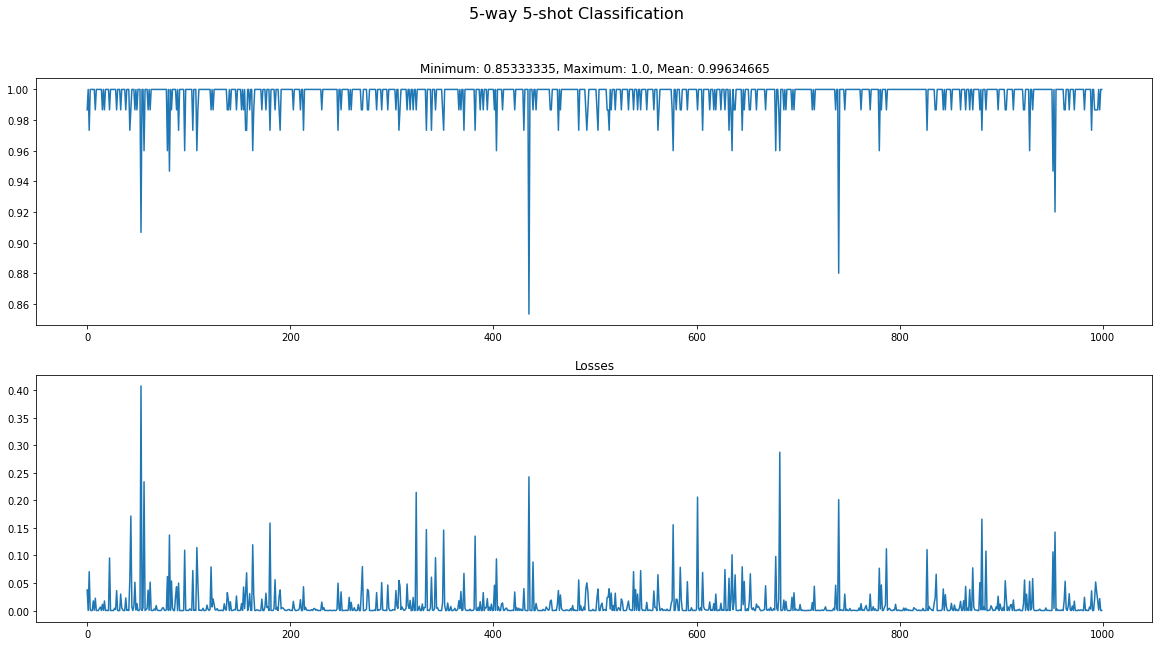

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
text = 'Minimum: ' +  str(min(test_accuracies).numpy()) + ', Maximum: ' + str(max(test_accuracies).numpy()) +  ', Mean: ' + str(tf.reduce_mean(test_accuracies).numpy())
plt.title(text)
plt.plot(steps, test_accuracies)
plt.subplot(2,1,2)
plt.title('Losses')
plt.plot(steps, test_losses)
title = str(TEST_CLASSES) + "-way " + str(TEST_SUPPORT) + "-shot Classification"
plt.suptitle(title,fontsize=16)
plt.show()

#### Discussion
In general, this experiment was reasonable to reimplement and reproduce. Most of the theoretical background was stated in a clear and understandable fashion, only some of the more specific details were not mentioned or hard to extract from the text. Terms like 'shot' and 'way' were used interchangably before the terms were properly defined in the paper. Further, the composition of the episodes was not entirely clear from the text. Additionally, there was no information about the number of epochs or episodes for training in the paper. We decided to use early stopping with a patience value of 200 which we determined by trial and error [9].

For the omniglot dataset, we were able to achieve values near to the average accuracy for all model types:

Type of classification | Accuracy of our implementation | Accuracy in paper 
---------------------- | ------------------------------ | --------------
5-way 1-shot | 98.0% | 98.8% (-0.8%)
5-way 5-shot |  98.9% | 99.7% (-0.8%)
20-way 1-shot | 93.2% | 96.0% (-2.8%)
20-way 5-shot | 96.1% | 98.9% (-2.8%)

Given these difference values, we can conclude that our reimplementation achieved subpar, but similar accuracy values for all types of classification for the Omniglot dataset.

### miniImageNet Dataset 

The second exepriment we replicate is few-shot classification performed on the _mini_ ImageNet dataset (Vinyals et al., 2016) which is a subset of the larger ImageNet dataset. It consists of 100 different image classes with 600 examples per class (84x84 RGB images), split in 64 training classes (38.400 images) and 20 test classes (12.000 images) (as proposed by Ravi and Larochelle in the original paper, 2017 [4]) (we do not use the additional 16 validation classes). The same network architecture is used as in the omniglot experiment. We replicate the 5-shot classifcation experiment by training on 20-way episodes with 5 support points (matching the test situation) and 15 query points per class each episode. 

The model is adjusted to the input shape (84, 84, 3) (RGB-images of shape 84x84):

In [ ]:
class PN(Model):
    def __init__(self):
        super(PN,self).__init__()
        self.cnn1 = tf.keras.layers.Convolution2D(filters=64,
                                                  kernel_size=3,
                                                  strides=(1,1),
                                                  padding='same',
                                                  activation=None,
                                                  input_shape=(None,84,84,3))
        self.batchnorm1 = tf.keras.layers.BatchNormalization()
        self.maxpool1 = tf.keras.layers.MaxPool2D((2,2))
        self.cnn2 = tf.keras.layers.Convolution2D(filters=64,
                                                  kernel_size=3,
                                                  strides=(1,1),
                                                  padding='same', 
                                                  activation=None)
        self.batchnorm2 = tf.keras.layers.BatchNormalization()
        self.maxpool2 = tf.keras.layers.MaxPool2D((2,2))
        self.cnn3 = tf.keras.layers.Convolution2D(filters=64,
                                                  kernel_size=3,
                                                  strides=(1,1),
                                                  padding='same',
                                                  activation=None)
        self.batchnorm3 = tf.keras.layers.BatchNormalization()
        self.maxpool3 = tf.keras.layers.MaxPool2D((2,2))
        self.cnn4 = tf.keras.layers.Convolution2D(filters=64,
                                                  kernel_size=3,
                                                  strides=(1,1),
                                                  padding='same',
                                                  activation=None)
        self.batchnorm4 = tf.keras.layers.BatchNormalization()
        self.maxpool4 = tf.keras.layers.MaxPool2D((2,2))
        self.flatten = tf.keras.layers.Flatten()

    def call(self,x,training):
        x = self.cnn1(x)
        x = self.batchnorm1(x,training=training)
        x = tf.nn.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = self.batchnorm2(x,training=training)
        x = tf.nn.relu(x)
        x = self.maxpool2(x)
        x = self.cnn3(x)
        x = self.batchnorm3(x,training=training)
        x = tf.nn.relu(x)
        x = self.maxpool3(x)
        x = self.cnn4(x)
        x = self.batchnorm4(x,training=training)
        x = tf.nn.relu(x)
        x = self.maxpool4(x)
        x = self.flatten(x)
        return x

The data was downloaded as compressed pickle files and uploaded in the group Colab folder. [Link to download the pickle files](https://github.com/renmengye/few-shot-ssl-public)

In [ ]:
# ******
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# *****
cd drive/'My Drive'/Data/imageNet

/content/drive/My Drive/Data/imageNet


In [ ]:
# *****
with open('mini-imagenet-cache-test.pkl', 'rb') as test_file:
  test_data = pickle.load(test_file)
with open('mini-imagenet-cache-train.pkl', 'rb') as train_file:
  train_data = pickle.load(train_file)

# numpy-arrays of shape (x,y,84,84,3) holding the data are created, 
# where x corresponds to a class and y corresponds to the image wihtin the class
data_test = np.zeros((20,600,84,84,3))
z = 0
for i in range(20): # classes
  for j in range(600): # examples per class 
    image = test_data['image_data'][z]
    z += 1
    data_test[i,j, :, :, :] = image

data_train = np.zeros((64,600,84,84,3))
z = 0
for i in range(64): # classes
  for j in range(600): # examples per class 
    image = train_data['image_data'][z]
    z += 1
    data_train[i,j, :, :, :] = image

The model is trained and training and test losses are calculated every ten episodes to monitore the learning success. The train accuracy is calculated for the current episode; the test accuracy and loss are calculated on one random test episode (we deemed this a reasonable approach since nothing specific was reported). We decided to use the test dataset containing 20 classes (we were not sure what was used in the original paper).

The 1-shot classification experiment can be easily  replicated using the same model by adjusting NUM_WAY and TEST_CLASSES to 30, NUM_SUPPORT and TEST_SUPPORT to 1. 

An issue that we faced was float number representation: some embedding values were very large negative numbers, by default represented as -inf, which resulted in NaN loss values. We solved this problem by casting the embeddings to float64.

Furthermore, sometimes the random initialization of the model led to a constant loss (it can bee easily monitored by outputting the loss vlaues whether they are constant in the first couple of steps) such that the model needed to be re-run.

In [ ]:
# ****
tf.keras.backend.clear_session()

NUM_WAY = 20 # set to 30 for the 1-shot experiment 
NUM_SUPPORT = 5  # set to 1 for the 1-shot experiment
NUM_QUERY = 15

TEST_CLASSES = 20 # set to 30 for the 1-shot experiment
TEST_SUPPORT = 5 # set to 1 for the 1-shot experiment 
TEST_QUERY = 15

# initializing model and optimizer
model = PN()
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps = 2000,
    decay_rate = 0.5,
    staircase=True 
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#begin training loop
w,h,c = 84,84,3
train_losses = []
ps = []
steps = []
train_steps = []
train_acc = []
grds = []

test_acc = []
test_steps = []
# accs1 = []
test_losses = []

step = 0
early_stopping = False
patience = 200
# create training episode
while not early_stopping:
# for step in range(2000):
    support, query = create_episode(data_train, NUM_WAY, NUM_SUPPORT, NUM_QUERY, w, h, c)
    # reshape support episode, so it can be processed by model
    s = tf.reshape(support, [NUM_WAY * NUM_SUPPORT, w, h, c])
    
    with tf.GradientTape() as tape:
        # compute embedding of support samples
        output = model(s,training=True)
        output = tf.cast(output, dtype=tf.float64)
        prototypes = tf.reshape(output,[NUM_WAY, NUM_SUPPORT, output.shape[-1]])
        # Prototypes are means of NUM_SUPPORT examples
        prototypes = tf.math.reduce_mean(prototypes, axis=1)
        # compute query points embedding
        q = tf.reshape(query, [NUM_WAY*NUM_QUERY,w,h,c])
        query_output = model(q,training = True)
        query_output = tf.cast(query_output, dtype = tf.float64)
        # distance here is squared euclidean distance between embedded query samples and prototypes
        dists = dist(query_output, prototypes)
        # reshape distance array to have shape (number of classes, embedded query samples per class, shape of embedding)
        dists = tf.reshape(dists,[NUM_WAY,NUM_QUERY,dists.shape[-1]])
          
        y = np.tile(np.arange(NUM_WAY)[:, np.newaxis], (1, NUM_QUERY))
        y_onehot = tf.cast(tf.one_hot(y, NUM_WAY), tf.float64)
        log_p_y = tf.nn.log_softmax(-dists, axis=-1)
        loss = tf.constant(0.0, dtype = tf.float64)
        # compute loss
        loss = -(tf.reduce_mean(tf.reshape(tf.reduce_sum(tf.multiply(y_onehot, log_p_y), axis=-1), [-1])))
        # print("total loss:", loss)
        gradients = tape.gradient(loss, model.trainable_variables)
    grds.append(gradients)    
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))
    steps.append(step)

    # test the training accuracy and record the loss every 10 steps
    if (step % 10) == 0:
      train_steps.append(step)
      train_losses.append(loss.numpy())
      log_p_y = tf.reshape(log_p_y, [NUM_WAY, NUM_QUERY, -1])
      eq = tf.cast(tf.equal(
                tf.argmax(log_p_y, axis=-1), y),
                tf.float32)
      accuracy = tf.reduce_mean(eq)
      train_acc.append(accuracy)

    # compute average test loss and accuracy on 1 episode
      test_loss = tf.constant(0.0, dtype = tf.float64)
      acc = 0
      
      test_support, test_query = create_episode(data_test, TEST_CLASSES, TEST_SUPPORT, TEST_QUERY, w, h, c)
      s = tf.reshape(test_support,[TEST_CLASSES*TEST_SUPPORT,w,h,c])
      # compute support embedding
      test_output = model(s,training=False)
      test_output = tf.cast(test_output, dtype = tf.float64)
      test_prototypes = tf.reshape(test_output,[TEST_CLASSES, TEST_SUPPORT, test_output.shape[-1]])
      # Prototypes are means of TEST_SUPPORT examples
      test_prototypes = tf.math.reduce_mean(test_prototypes, axis=1)
      q = tf.reshape(test_query, [TEST_CLASSES*TEST_QUERY,w,h,c])
      # compute query embedding
      query_output = model(q,training = False)
      query_output = tf.cast(query_output, dtype = tf.float64)
      # distance here is squared euclidean distance between embedded query samples and prototypes
      test_dists = dist(query_output, test_prototypes)
      # reshape distance array to have shape (number of classes, embedded query samples per class, shape of embedding)
      test_dists = tf.reshape(test_dists,[TEST_CLASSES,TEST_QUERY,test_dists.shape[-1]])
      y = np.tile(np.arange(TEST_CLASSES)[:, np.newaxis], (1, TEST_QUERY))
      y_onehot = tf.cast(tf.one_hot(y, TEST_CLASSES), tf.float64)
      log_p_y = tf.nn.log_softmax(-test_dists, axis=-1)
        # calculate loss 
      test_loss = -(tf.reduce_mean(tf.reshape(tf.reduce_sum(tf.multiply(y_onehot, log_p_y), axis=-1), [-1])))
      log_p_y = tf.reshape(log_p_y, [TEST_CLASSES, TEST_QUERY, -1])
      # calculate accuracy
      eq = tf.cast(tf.equal(
                  tf.cast(tf.argmax(log_p_y, axis=-1), tf.int32), 
                  tf.cast(y, tf.int32)), tf.float32)
      acc += tf.reduce_mean(eq)
              
      test_acc.append(acc)
      test_steps.append(step)
      test_losses.append(test_loss)

    step += 1
    
    if len(train_losses) > patience and max(train_losses[-patience:]) == train_losses[-1]:
      early_stopping = True
print('Number of training steps: ', step)        

Number of training steps:  9981


#### Results on the miniImageNet dataset using squared Euclidean distance

We achieve a good minimization of the train loss. However, we fail to achieve an accuracy that would be close to the reported results. A higher number of training episodes could possibly lead to better performance (no specific number of used episodes is reported in the paper, so we also implement early stopping). The way early stopping is implemeted it might overtrain a little in terms of the number of episodes (since the current value needs to match the maximal value of previous 200 steps exaclty). To be able to evaluate performance we also used 2000 training episodes (early stopping was taking too long - more than 4 hours - on this dataset).

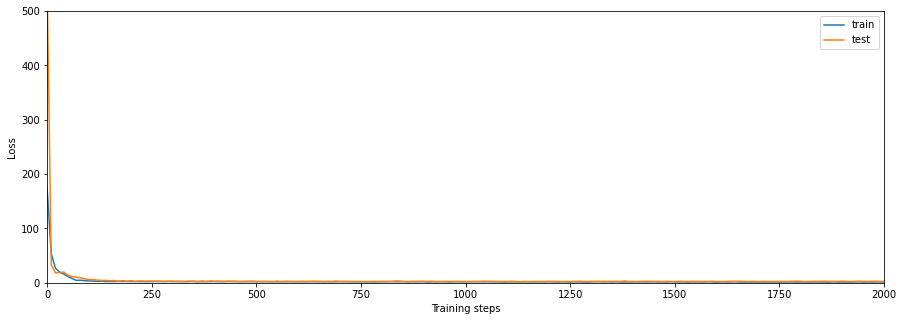

In [ ]:
plt.figure(figsize=(15, 5))
plt.axis([0, 2000, 0, 500])
line1, = plt.plot(train_steps, train_losses)
line2, = plt.plot(test_steps, test_losses)
plt.legend((line1,line2),("train", "test"))
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()


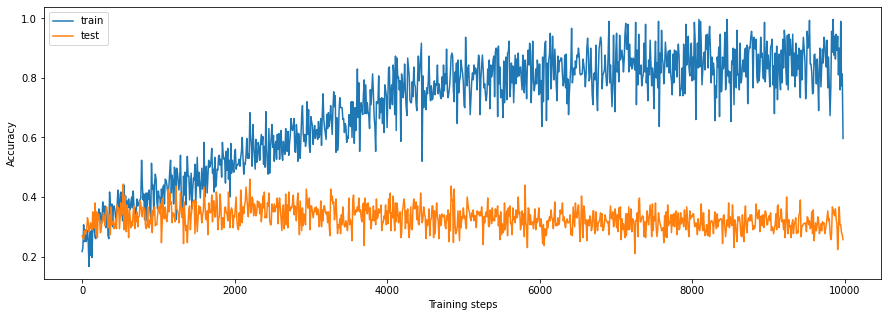

In [ ]:
plt.figure(figsize=(15,5))
line1, = plt.plot(train_steps, train_acc)
line2, = plt.plot(test_steps, test_acc)
plt.legend((line1,line2),("train", "test"))
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()

To calculate the final classification accuracy, we test the model on 600 randomly generated test episodes as reported in the original paper and compute the mean.

In [ ]:
# ***
TEST_CLASSES = 20
TEST_SUPPORT = 5
TEST_QUERY = 15

w, h, c = 84, 84, 3
final_test_acc = []
final_test_steps = []
final_test_losses = []
step = 0

for step in range(600):
      test_loss = tf.constant(0.0, dtype = tf.float64)
      acc = 0
      test_support, test_query = create_episode(data_test, TEST_CLASSES, TEST_SUPPORT, TEST_QUERY, w, h, c)
      s = tf.reshape(test_support,[TEST_CLASSES*TEST_SUPPORT,w,h,c])
      # compute support embedding
      test_output = model(s,training=False)
      test_output = tf.cast(test_output, dtype = tf.float64)
      test_prototypes = tf.reshape(test_output,[TEST_CLASSES, TEST_SUPPORT, test_output.shape[-1]])
      # Prototypes are means of TEST_SUPPORT examples
      test_prototypes = tf.math.reduce_mean(test_prototypes, axis=1)
      q = tf.reshape(test_query, [TEST_CLASSES*TEST_QUERY,w,h,c])
      # compute query embedding
      query_output = model(q,training = False)
      query_output = tf.cast(query_output, dtype = tf.float64)
      # distance here is squared euclidean distance between embedded query samples and prototypes
      test_dists = dist(query_output, test_prototypes)
      # reshape distance array to have shape (number of classes, embedded query samples per class, shape of embedding)
      test_dists = tf.reshape(test_dists,[TEST_CLASSES,TEST_QUERY,test_dists.shape[-1]])
      y = np.tile(np.arange(TEST_CLASSES)[:, np.newaxis], (1, TEST_QUERY))
      y_onehot = tf.cast(tf.one_hot(y, TEST_CLASSES), tf.float64)
      log_p_y = tf.nn.log_softmax(-test_dists, axis=-1)
        # calculate loss 
      test_loss = -(tf.reduce_mean(tf.reshape(tf.reduce_sum(tf.multiply(y_onehot, log_p_y), axis=-1), [-1])))
      log_p_y = tf.reshape(log_p_y, [TEST_CLASSES, TEST_QUERY, -1])
      # calculate accuracy
      eq = tf.cast(tf.equal(
                  tf.cast(tf.argmax(log_p_y, axis=-1), tf.int32), 
                  tf.cast(y, tf.int32)), tf.float32)
      acc += tf.reduce_mean(eq)
              
      final_test_acc.append(acc)
      final_test_steps.append(step)
      final_test_losses.append(test_loss)

      step += 1

print('Mean test accuracy on 600 random test episodes:', tf.reduce_mean(final_test_acc).numpy())  

Mean test accuracy on 600 random test episodes: 0.30815




#### Results on the miniImageNet dataset using cosine similarity

In order to show the role of the chosen distance metric, we also replicate an experiment using a prototypical network with cosine similarity as the distance metric between prototypes and query points:

$similarity = \frac{\sum_{i=1}^{n}A _i B _i}{\sqrt{\sum_{i=1}^{n}A _i^2}\sqrt{\sum_{i=1}^{n}B _i^2}}$

We compare the results for the 5-shot classification experiment trained on 20-way episodes with 5 support and 15 query points.

In [ ]:
def cosine_dist(q, p):
  n = q.shape[0]
  m = p.shape[0]
  q = tf.tile(tf.expand_dims(q, 1), [1, m, 1])
  p = tf.tile(tf.expand_dims(p, 0), [n, 1, 1])
  cosine_dist = tf.math.divide_no_nan(tf.reduce_sum(tf.math.multiply(q, p), axis=-1), tf.math.multiply( tf.math.sqrt(tf.reduce_sum(q**2, axis=-1)), tf.math.sqrt(tf.reduce_sum(p**2, axis=-1))))
  return cosine_dist

The model is trained using cosine similarity as the distance metric. Same accuracy computations as above are performed for generalization performance monitoring. 

We encounter the issue that some distance values had NaN entries whenever a prorotype or an embedding included the space origin, immediately resulting in NaN loss values. We solved this by implementing the cosine distance using `tf.math.divide_no_nan()` such that distances to these embeddings were just represented as zeros. 
Again, early stopping might take too long so using 2000 training episodes might be better in order to get an idea of the performance.  

In [ ]:
# ****
tf.keras.backend.clear_session()
NUM_WAY = 20
NUM_SUPPORT = 5 
NUM_QUERY = 15

TEST_CLASSES = 20
TEST_SUPPORT = 5
TEST_QUERY = 15

# initializing model and optimizer
model_cosine = PN()
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps = 2000,
    decay_rate = 0.5,
    staircase=True #
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#begin training loop
w,h,c = 84,84,3
train_cosine_losses = []
train_steps = []
cosine_steps = []
cosine_grds = []
train_cosine_acc = []
test_cosine_acc = []
test_steps = []
test_cosine_losses = []

step = 0
early_stopping = False
patience = 200
# create training episode
while not early_stopping:
# for step in range(2000):
    support, query = create_episode(data_train, NUM_WAY, NUM_SUPPORT, NUM_QUERY, w, h, c)
    # reshape support episode, so it can be processed by model
    s = tf.reshape(support, [NUM_WAY * NUM_SUPPORT, w, h, c])
    # compute embedding of support samples
    with tf.GradientTape() as tape:
        output = model_cosine(s,training=True)
        output = tf.cast(output, dtype=tf.float64)
        prototypes = tf.reshape(output,[NUM_WAY, NUM_SUPPORT, output.shape[-1]])
        # Prototypes are means of NUM_SUPPORT examples
        prototypes = tf.math.reduce_mean(prototypes, axis=1)
        q = tf.reshape(query, [NUM_WAY*NUM_QUERY,w,h,c])
        # compute query embedding
        query_output = model_cosine(q,training = True)
        query_output = tf.cast(query_output, dtype = tf.float64)
        # distance here is cosine similarity between embedded query samples and prototypes
        dists = cosine_dist(query_output, prototypes)
        # reshape distance array to have shape (number of classes, embedded query samples per class, shape of embedding)
        dists = tf.reshape(dists,[NUM_WAY,NUM_QUERY,dists.shape[-1]])
        y = np.tile(np.arange(NUM_WAY)[:, np.newaxis], (1, NUM_QUERY))
        y_onehot = tf.cast(tf.one_hot(y, NUM_WAY), tf.float64)
        log_p_y = tf.nn.log_softmax(-dists, axis=-1)
        loss = tf.constant(0.0, dtype = tf.float64)
        # compute loss
        loss = -(tf.reduce_mean(tf.reshape(tf.reduce_sum(tf.multiply(y_onehot, log_p_y), axis=-1), [-1])))
        gradients = tape.gradient(loss, model_cosine.trainable_variables)
    cosine_grds.append(gradients)    
    optimizer.apply_gradients(zip(gradients, model_cosine.trainable_variables))
    cosine_steps.append(step)
# compute training accuracy and record it and the loss every 10 steps 
    if (step % 10) == 0:
      train_steps.append(step)
      train_cosine_losses.append(loss.numpy())
      log_p_y = tf.reshape(log_p_y, [NUM_WAY, NUM_QUERY, -1])
      eq = tf.cast(tf.equal(
                tf.argmax(log_p_y, axis=-1), y),
                tf.float32)
      accuracy = tf.reduce_mean(eq)
      train_cosine_acc.append(accuracy)
      
    # compute average test loss and accuracy on 1 test episode
      test_loss = tf.constant(0.0, dtype = tf.float64)
      acc = 0     
      test_support, test_query = create_episode(data_test, TEST_CLASSES, TEST_SUPPORT, TEST_QUERY, w, h, c)
      s = tf.reshape(test_support,[TEST_CLASSES*TEST_SUPPORT,w,h,c])
      test_output = model_cosine(s,training=False)
      test_output = tf.cast(test_output, dtype = tf.float64)
      test_prototypes = tf.reshape(test_output,[TEST_CLASSES, TEST_SUPPORT, test_output.shape[-1]])
      # Prototypes are means of TEST_SUPPORT examples
      test_prototypes = tf.math.reduce_mean(test_prototypes, axis=1)
      q = tf.reshape(test_query, [TEST_CLASSES*TEST_QUERY,w,h,c])
      query_output = model_cosine(q,training = False)
      query_output = tf.cast(query_output, dtype = tf.float64)
      # distance here is cosine similarity between embedded query samples and prototypes
      test_dists = cosine_dist(query_output, test_prototypes)
      # reshape distance array to have shape (number of classes, embedded query samples per class, shape of embedding)
      test_dists = tf.reshape(test_dists,[TEST_CLASSES,TEST_QUERY,test_dists.shape[-1]])
      y = np.tile(np.arange(TEST_CLASSES)[:, np.newaxis], (1, TEST_QUERY))
      y_onehot = tf.cast(tf.one_hot(y, TEST_CLASSES), tf.float64)
      # compute loss
      log_p_y = tf.nn.log_softmax(-test_dists, axis=-1)
      test_loss = -(tf.reduce_mean(tf.reshape(tf.reduce_sum(tf.multiply(y_onehot, log_p_y), axis=-1), [-1])))
      log_p_y = tf.reshape(log_p_y, [TEST_CLASSES, TEST_QUERY, -1])
      # compute accuracy
      eq = tf.cast(tf.equal(
                  tf.cast(tf.argmax(log_p_y, axis=-1), tf.int32), 
                  tf.cast(y, tf.int32)), tf.float32)
      acc += tf.reduce_mean(eq)
      test_cosine_acc.append(acc)
      test_steps.append(step)
      test_cosine_losses.append(test_loss)

    step += 1
    
    if len(train_cosine_losses) > patience and max(train_cosine_losses[-patience:]) == train_cosine_losses[-1]:
      early_stopping = True
print('Number of training steps: ', step)        

Number of training steps:  10671


The results we achieve with the cosine similarity as the distance metric are considerably worse than those achieved with the squared Euclidean distance. Hence we can confirm the importance of the distance metric and the better performance of the squared Euclidean distance (according to the authors, because it is a regular Bregman divergence, whereas the cosine similarity is not).

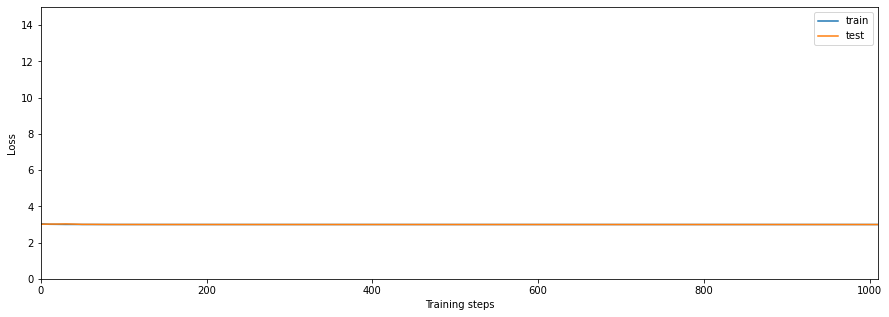

In [ ]:
plt.figure(figsize=(15, 5))
plt.axis([0, 1010, 0, 15])
line1, = plt.plot(train_steps, train_cosine_losses)
line2, = plt.plot(test_steps, test_cosine_losses)
plt.legend((line1,line2),("train", "test"))
# plt.plot(train_steps, train_acc)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

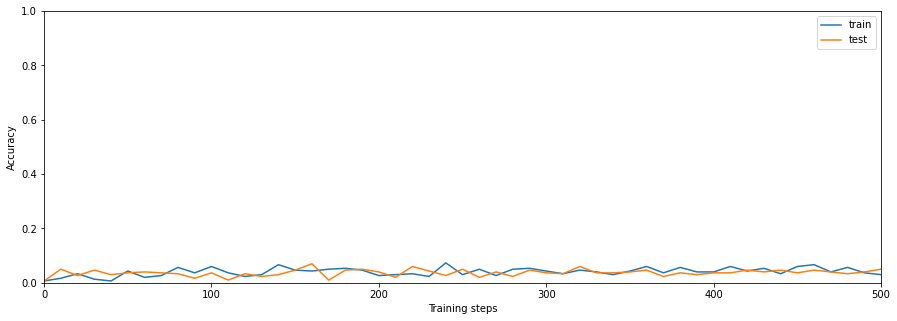

In [ ]:
plt.figure(figsize=(15, 5))
plt.axis([0, 500, 0, 1])
line1, = plt.plot(train_steps, train_cosine_acc)
line2, = plt.plot(test_steps, test_cosine_acc)
plt.legend((line1,line2),("train", "test"))
# plt.plot(test_steps, test_acc)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()

To compute the final test accuracy, we calculate the mean classification accuracy on 600 random test episodes, as reported in the original paper.

In [ ]:
# ****
TEST_CLASSES = 20
TEST_SUPPORT = 5
TEST_QUERY = 15

w, h, c = 84, 84, 3
final_test_cosine_acc = []
final_test_steps = []
final_test_cosine_losses = []
step = 0
for step in range(600):
      test_loss = tf.constant(0.0, dtype = tf.float64)
      acc = 0
      test_support, test_query = create_episode(data_test, TEST_CLASSES, TEST_SUPPORT, TEST_QUERY, w, h, c)
      s = tf.reshape(test_support,[TEST_CLASSES*TEST_SUPPORT,w,h,c])
      # compute support embedding
      test_output = model_cosine(s,training=False)
      test_output = tf.cast(test_output, dtype = tf.float64)
      test_prototypes = tf.reshape(test_output,[TEST_CLASSES, TEST_SUPPORT, test_output.shape[-1]])
      # Prototypes are means of TEST_SUPPORT examples
      test_prototypes = tf.math.reduce_mean(test_prototypes, axis=1)
      q = tf.reshape(test_query, [TEST_CLASSES*TEST_QUERY,w,h,c])
      # compute query embedding
      query_output = model_cosine(q,training = False)
      query_output = tf.cast(query_output, dtype = tf.float64)
      # distance here is squared euclidean distance between embedded query samples and prototypes
      test_dists = cosine_dist(query_output, test_prototypes)
      # reshape distance array to have shape (number of classes, embedded query samples per class, shape of embedding)
      test_dists = tf.reshape(test_dists,[TEST_CLASSES,TEST_QUERY,test_dists.shape[-1]])
      y = np.tile(np.arange(TEST_CLASSES)[:, np.newaxis], (1, TEST_QUERY))
      y_onehot = tf.cast(tf.one_hot(y, TEST_CLASSES), tf.float64)
      log_p_y = tf.nn.log_softmax(-test_dists, axis=-1)
        # calculate loss 
      test_loss = -(tf.reduce_mean(tf.reshape(tf.reduce_sum(tf.multiply(y_onehot, log_p_y), axis=-1), [-1])))
      log_p_y = tf.reshape(log_p_y, [TEST_CLASSES, TEST_QUERY, -1])
      # calculate accuracy
      eq = tf.cast(tf.equal(
                  tf.cast(tf.argmax(log_p_y, axis=-1), tf.int32), 
                  tf.cast(y, tf.int32)), tf.float32)
      acc += tf.reduce_mean(eq)
              
      final_test_cosine_acc.append(acc)
      final_test_steps.append(step)
      final_test_cosine_losses.append(test_loss)

      step += 1

print('Mean test accuracy on 600 random test episodes with cosine distance:', tf.reduce_mean(final_test_cosine_acc).numpy())  

Mean test accuracy on 600 random test episodes with cosine distance: 0.04091111


We compare the final test accuracies of the prototypical network using squared Euclidean distance versus cosine similarity. 

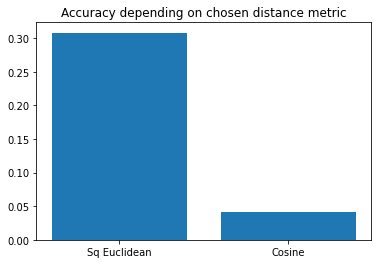

In [ ]:
labels = ['Sq Euclidean', 'Cosine']
test_acc_means = [0.30815, tf.reduce_mean(final_test_cosine_acc).numpy()]
plt.figure()
plt.bar(labels, test_acc_means)
plt.title('Accuracy depending on chosen distance metric')
plt.show()

#### Discussion 

The reimplementation was feasible given the descriptions provided in the paper, accounting for the issues discussed above. Additionally, we found that the loss description was somewhat ambiguos and the testing of the network's generalization performance was not described in detail. The values in table below were computed earlier adjusting the respective shot and way number. 

Type of classification (distance metric) | Nr of training episodes | Accuracy of our implementation | Accuracy in paper 
---------------------- |--------------| ------------------------------ | --------------
5-way 1-shot (Euclidean) | 2000 | 35.3% | 49.42%
5-way 1-shot (cosine) | 2000 | 19.43% | 42.48%
5-way 5-shot (Euclidean) | 2000 | 37.19% | 68.2%
5-way 5-shot (cosine) | -- | -- | 51.23%
20-way 1-shot (Euclidean) | 2000 | 19.93% | 48.57%
20-way 1-shot (cosine) | 2000 | 4.84% | 43.64%
20-way 5-shot (Euclidean) | 9981 | 31% | 68.2%
20-way 5-shot (cosine)| 10671 | 4% | 51.34%

We fail to improve the test accuracies to be near the reported accuracies, although we used the architecture which lead to good performance on the omniglot dataset and followed the discriptions in the paper. The cause of this misperformance remains to be investiagted. Given the tendency showing an increasing generalization accuracy, we hypothesize that a longer training time might lead to a better performance. 

## Zero-shot learning on the CUB-Dataset

### On zero-shot learning

The zero-shot learning method is a type of learning for neural networks. It is based on the idea of 'learning to learn' from metadata.

Hereby a network is trained on some data, in this specific case on bird images and bird metadata. The metadata is some form of high level description, i.e. [crow: black, medium size, black beak, black feet, shiny feathers]. The dataset is parted, so that the net is only trained on some of the existing birds. After the net can classify those correctly with sufficient accuracy and reasonably little overfitting, new bird images with new metadata can be presented to the network which it then has to classify  without previous training.

The main idea underlying the learning is that the net is able to abstract from image to metadata and thereby classify the bird in the image. The ability to do this abstraction is still present when the net is applied to data it had never seen before (hence performing classification to classes it has never seen an instance of before,  i.e. from _zero-shots_). This is why the net, given new image and matching metadata, can infer the bird type from the image only having been trained on different bird species.

In [ ]:
# ZERO_SHOT CLASSIFICATION

# on CUB 200-2011 dataset

import numpy as np
%tensorflow_version 2.x # decomment this line in Colab
import tensorflow as tf
import tensorflow_datasets as tfds
tf.__version__
import matplotlib.pyplot as plt

# check if this returns True
# to enable iterating over dataset
tf.executing_eagerly()

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x # decomment this line in Colab`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


True

### The caltech CUB-2002011 dataset

The Caltech CUB-2002011 dataset consists of 11788 RGB images of 200 different bird species with around 60 images per species (classes). The images are of different sizes, have varying backgrounds and states (e.g. flying, sitting).
Below is a grid of 25 birds to get an impression of the images.

Make sure to specify where to save the data in 'path = '.

Shuffling and writing examples to data/cub/caltech_birds2011/0.1.0.incompleteF9HB6K/caltech_birds2011-train.tfrecord


Shuffling and writing examples to data/cub/caltech_birds2011/0.1.0.incompleteF9HB6K/caltech_birds2011-test.tfrecord


Dataset caltech_birds2011 downloaded and prepared to data/cub/caltech_birds2011/0.1.0. Subsequent calls will reuse this data.


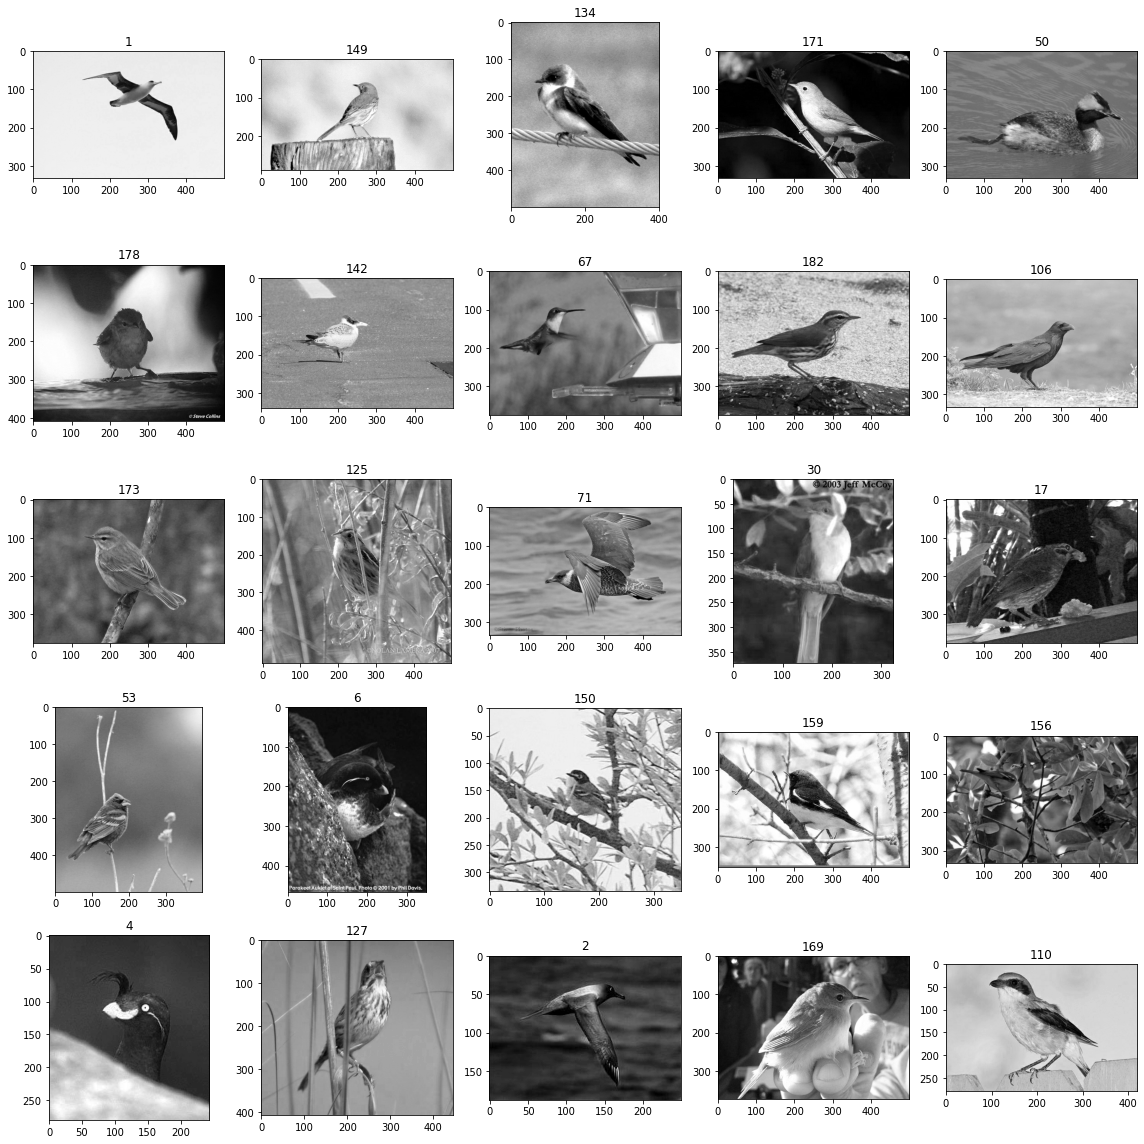

In [ ]:
# ***** whole cell

# ++++++++++++++++++++++++
# LOOK AT DATASET EXAMPLES
# ++++++++++++++++++++++++

# SPECIFY
path = 'data/cub'

# load part of CUB dataset
train_ds, info = tfds.load('caltech_birds2011',split ="train", with_info=True, data_dir=path)

# visualize
fig=plt.figure(figsize=(16, 16))
columns = 5
rows = 5

# go through every point in plotting grid
for i in range(1, columns*rows+1):
    
    # take different example each time
    for show_example in train_ds.take(i):
        # get image-data and label
        image, label = show_example["image"], show_example["label"]

    # add image and label to plotting grid
    fig.add_subplot(rows, columns, i)
    plt.imshow(image.numpy()[:, :, 0].astype(np.float32), cmap=plt.get_cmap("gray"))
    # set label as title
    plt.title(label.numpy())
    # get nicer layout
    plt.tight_layout()

plt.show()

### The CUB dataset for zero-shot classification

The zero-shot approach needs the data to be sorted by classes. This is unusual: typical learning needs a good representation of all classes to infer from many examples to other examples of the same classes.
**In zero-shot we focus on learning the abstraction process from images to metadata independent of content and experience with other instances of a class.** To test this, it is obvious that we need to have classes that have never been seen before, else we can not say if the network classified by understanding the metadata or by experience from previous instances of this species.

Typical usage of tensorflow datasets does not allow this split. This is why we decided to download the dataset and split is customized to our needs.

**The procedure to get disjoint datasets is:**
+ read class names from directory names in the database into a list
+ shuffle the list
+ split into test, train and validation classes
+ for every set, get paths to all images of this class
+ from every path load the image


In [ ]:
# needs the dataset imported manually into folder that is walked through


# *** rest of cell
# imports
from random import shuffle
import os
import glob
from PIL import Image
import cv2
import numpy as np
import random as rand
path = "content/drive/'My Drive'/Data/cub"
# read classnames from directorynames in database into a list
classnames = []
for (dirpath, dirnames, filenames) in os.walk(path+'/CUB_200_2011/images'):
  # append path for every directory path (subfolder)
  classnames.append(dirpath)

In [ ]:
# +++++++++++++++++++++++++
# GET AND PREPARE META DATA
# +++++++++++++++++++++++++
# 312 attribute vectors provided with dataset
# every row is a class and the numbers are the certainites of human labellers in 312 categories

attr_vec = np.arange(200 * 312, dtype=float).reshape(200, 312)
# open file
filepath = path+'/CUB_200_2011/attributes/class_attribute_labels_continuous.txt'
with open(filepath) as file:
    # for every class
    for r, row in enumerate(file):
        # save every value in the vector
        vector = row.split()
        for v, val in enumerate(vector):
            # in the metadata array
            attr_vec[r][v] = val
            
# transform into list
meta_vec_list = []
for line in attr_vec:
    meta_vec_list.append(line)

In [ ]:
# ++++++++++++++++++++++++++++++++++++++
# SPLIT INTO TRAIN TEST AND VAL DATASETS
# ++++++++++++++++++++++++++++++++++++++

# shuffle the data
# with common seed so label and image are still in same order
rand.Random(3).shuffle(meta_vec_list)
rand.Random(3).shuffle(classnames)

# split into test train and validation classes
# 100 training classes
train_classes = []
for dirpath in classnames[0:100]:
    train_classes.append(sorted(glob.glob(os.path.join(dirpath+'\\', '*.jpg'))))
# 50 validation classes
test_classes = []
for dirpath in classnames[100:150]:
    test_classes.append(sorted(glob.glob(os.path.join(dirpath+'\\', '*.jpg'))))
# 50 test classes
val_classes = []
for dirpath in classnames[150:200]:
    val_classes.append(sorted(glob.glob(os.path.join(dirpath+'\\', '*.jpg'))))
    
# meta data: do same split
# keeps correct order
train_meta = []
for vec in meta_vec_list[0:100]:
    train_meta.append(vec)
test_meta = []
for vec in meta_vec_list[100:150]:
    test_meta.append(vec)
val_meta = []
for vec in meta_vec_list[150:200]:
    val_meta.append(vec)

### The 100-50(-50) split

This was used by Snell et al. [2]
On the imageNet, Rohrbach et al. [7] use a 800 training classes - 200 testing classes split which is leaning more towards training data than 100-50 but is also larger in total. Other datasets have a more evenly distributed split, e.g. A.Farhadi et al. [8] use a 15-12 split, with a smaller dataset in total.

The proposed 100-50-(50) distribution is in a good middle with respect to both size and split, hence we think that this is reasonable to use.

In [ ]:
# for every train/test/val set
# get paths to all images of this class
# in one list
# make sure to add the class metadata as many times
# to the metadata list as you add an image of that class
#  -> metadata and image lists stay in equal length and order


# for train
train_img_paths = []
train_metaPerImage = []
for i, birdclass in enumerate(train_classes):
    for img in birdclass:
        # for every imagefile of class <crow> add the image of the <crow>
        train_img_paths.append(img)
        # and as many times add the metadata to <crow>
        train_metaPerImage.append(train_meta[i])
# for test
test_img_paths = []
test_metaPerImage = []
for i, birdclass in enumerate(test_classes):
    for img in birdclass:
        test_img_paths.append(img)
        test_metaPerImage.append(test_meta[i])
# for val
val_img_paths = []
val_metaPerImage = []
for i, birdclass in enumerate(val_classes):
    for img in birdclass:
        val_img_paths.append(img)
        val_metaPerImage.append(val_meta[i])

In [ ]:
#**** whole cell
# from every path load the image
train_imgs = []
for path in train_img_paths:
    img = cv2.imread(path)
    train_imgs.append(img)
test_imgs = []
for path in test_img_paths:
    img = cv2.imread(path)
    test_imgs.append(img)
val_imgs = []
for path in val_img_paths:
    img = cv2.imread(path)
    val_imgs.append(img)
    
print('type of train_imgs: ', type(train_imgs))
print('type of train_imgs[0]: ', type(train_imgs[0]))
    
# get impression of sizes and distribution:
# print(len(train_imgs), len(test_imgs), len(val_imgs))
# 5923, 2932, 2874
# mirrors 100-50-50 split -> good

### Dataset augmentation

The variance in the images is quite high, as the birds are captured flying, on the ground, picking things, standing, walking, in bushes, in front of the sky, from different angles an so on.
But **to achieve even more data for training and testing and to achieve better invariance against occlusions and mirroring**, the dataset is augmented from 11.788 images to 117.880 images. Each is cropped (middle, upper left, upper right, lower left, lower right) and every crop is flipped horizontally and not flipped.
= (5 * 11.788 crops) * 2 (flip and original) = 117.880 images

Augmentation is good for the mentioned reasons, but since the network is praised for achieving state-of-the-art results, it is questionnable if such results can be achieved with other databases as well. In many applications, the amount of examples with labels/metadata is limited, and slighty worse performance on a more frequently found size of datasets (that are of **use in 'real life applications'**) might be more useful, than very good performance on 'artificial datasets' for research purposes.

In [ ]:
#**** 

print(len(train_imgs)==len(train_metaPerImage))
print(len(train_metaPerImage))

In [ ]:
# define cropping functions for ndarrays
# all into size 112x112(x3) to fit into the network input
def crop_middle(image):
    # get size of image, third shape-value is color-dimension
    height, width, _ = image.shape  
    return img[(height-112)//2 : ((height - 112)//2)+112, (width-112)//2 : ((width - 112)//2)+112]

def crop_topleft(image):
    # get size of image, third shape-value is color-dimension
    height, width, _ = image.shape
    return img[0:112, 0:112]

def crop_topright(image):
    # get size of image, third shape-value is color-dimension
    height, width, _ = image.shape
    return img[0:112, -112:width]

def crop_lowerleft(image):
    # get size of image, third shape-value is color-dimension
    height, width, _ = image.shape
    return img[-112:height, 0:112]

def crop_lowerright(image):
    # get size of image, third shape-value is color-dimension
    height, width, _ = image.shape 
    return img[-112:height, -112:width]

In [ ]:
# ***** whole cell
#  ++++++++++++++++++++++++++++++++++++
# AUGMENT DATASET
# ++++++++++++++++++++++++++++++++++++
import numpy as np
import random as rand

# limit batch size because of computing resources
# set this to <len(train_imgs)> when computing online, batch size will be decided later then!
use_imgs = 10 #len(train_imgs)
train_use_imgs = train_imgs[0:use_imgs]
print(len(train_use_imgs))
print((train_use_imgs[0]).shape)

In [ ]:
train_imgAug = []
train_metaAug = []

# augment every image
for i, image in enumerate(train_use_imgs):
    train_imgAug.append(crop_middle(image))
    train_imgAug.append(crop_topleft(image))
    train_imgAug.append(crop_topright(image))
    train_imgAug.append(crop_lowerleft(image))
    train_imgAug.append(crop_lowerright(image))
    train_imgAug.append(np.fliplr(image))
    
    # for every augmentation of an image from a certain class
    # add the metadata of this class to the metadata list
    # -> metadata and image lists stay in equal length and order
    for j in range(6):
        train_metaAug.append(train_metaPerImage[i])

# shuffle, so the classes are mixed
# same seed  -> metadata and image lists stay in equal length and order
rand.Random(4).shuffle(train_imgAug)
rand.Random(4).shuffle(train_metaAug)

In [ ]:
# do the same as in the cell above for test and validation data

# ++++++++++++++++++ test data ++++++++++++++++++++++++++++
test_imgAug = []
test_metaAug = []

# augment every image
for i, image in enumerate(test_imgs):
    test_imgAug.append(image)
    test_imgAug.append(crop_middle(image))
    test_imgAug.append(crop_topleft(image))
    test_imgAug.append(crop_topright(image))
    test_imgAug.append(crop_lowerleft(image))
    test_imgAug.append(crop_lowerright(image))
    test_imgAug.append(np.fliplr(image))
    
    # for every augmentation of an image from a certain class
    # add the metadata of this class to the metadata list
    # -> metadata and image lists stay in equal length and order
    for j in range(7):
        test_metaAug.append(test_metaPerImage[i])

# shuffle, so the classes are mixed
# same seed  -> metadata and image lists stay in equal length and order
rand.Random(4).shuffle(test_imgAug)
rand.Random(4).shuffle(test_metaAug)


# ++++++++++++++++++ validation data ++++++++++++++++++++++++++++
val_imgAug = []
val_metaAug = []

# augment every image
for i, image in enumerate(val_imgs):
    val_imgAug.append(image)
    val_imgAug.append(crop_middle(image))
    val_imgAug.append(crop_topleft(image))
    val_imgAug.append(crop_topright(image))
    val_imgAug.append(crop_lowerleft(image))
    val_imgAug.append(crop_lowerright(image))
    val_imgAug.append(np.fliplr(image))
    
    # for every augmentation of an image from a certain class
    # add the metadata of this class to the metadata list
    # -> metadata and image lists stay in equal length and order
    for j in range(7):
        val_metaAug.append(val_metaPerImage[i])

# shuffle, so the classes are mixed
# same seed  -> metadata and image lists stay in equal length and order
rand.Random(4).shuffle(val_imgAug)
rand.Random(4).shuffle(val_metaAug)

In [ ]:
plt.imshow(train_imgAug[1])
plt.show()
print('metadata: ', len(train_metaAug[0]), '- valued meta vector')

In [ ]:
# +++++++++++++++++
# BUILD THE NETWORK
# +++++++++++++++++

# imports:
from tensorflow.keras.layers import Layer

### GoogLeNet
The GoogLeNet, proposed by C. Szegedy et al. [1], is used to extract features from the bird images. The features are 1024-dimensional, and extracted from the augmented dataset.
The hope is that these features correspond to bird features in the images: e.g. an orange beak, brownish feathers and medium size. These features can then later be matched against the metadata by a prototypical network.

A known advantage of the GoogLeNet is its inception architecture.
The inception architecture allows high accurracy with fewer parameters than equivalent other networks have. This is achieved by not only a higher depth but also a better organization of layers in the inception module - this reduces computational cost and allows applications on real world datasets. 

However, if the network is large it easily overfits due to its many parameters, especially if only small datasets are available. This has to be checked thouroughly when choosing the data and training the network, e.g. by cross-validation.


#### Architecture
The 1x1 convolutions are of high use for dimension reduction and therefore facilitaton of computational efforts and avoiding bottlenecks, allowing to spend the saved effort on increased depth to improve performance ( i.e. it's an efficient redistribution of computational resources).

In [ ]:
# ++++++++++++++++++++++
# GOOGLENET ARCHITECTURE
# ++++++++++++++++++++++
# commented layers are there only as an overview over the architecture
# they have no other functional purpose here

class Model(Layer):

    def __init__(self):
        super(Model, self).__init__()
        # define the layers as in GoogLeNet
        self.cnn1 = tf.keras.layers.Convolution2D(filters=64,
                                                  kernel_size=7,
                                                  strides=(2),
                                                  activation=tf.keras.activations.relu,
                                                  input_shape=(112, 112, 3))
                                                  # output shape 112x112x64
            
        self.maxpool1 = tf.keras.layers.MaxPool2D((3,3))
                                                  # output shape 56x56x64
            
        self.cnn2 = tf.keras.layers.Convolution2D(filters=192,
                                                  kernel_size=3,
                                                  strides=(1,1),
                                                  activation=tf.keras.activations.relu)
                                                  # output shape 56x56x192
            
        self.maxpool2 = tf.keras.layers.MaxPool2D(pool_size=(3,3),
                                                  strides=(2,2))
                                                  # output shape 28x28x192
            
        # inception layers are defined below
        '''
        self.inception3a = inception2a(x) # output shape 28x28x256
        self.inception3b = inception2b(x) # output shape 28x28x480
        '''
        self.maxpool3 = tf.keras.layers.MaxPool2D(pool_size=(3,3),
                                                  strides=(2,2))
                                                  # output shape 14x14x480
        '''
        self.inception4a = inception3a(x) # output shape 14x14x512
        self.inception4b = inception3b(x) # output shape 14x14x512
        self.inception4c = inception3c(x) # output shape 14x14x512
        self.inception4d = inception3d(x) # output shape 14x14x528
        self.inception4e = inception3e(x) # output shape 14x14x832
        '''
        self.maxpool4 = tf.keras.layers.MaxPool2D(pool_size=(3,3),
                                                  strides=(2,2))
                                                  # output shape 7x7x832
        '''
        self.inception5a = inception4a(x) # output shape 7x7x832
        self.inception5b = inception4b(x) # output shape 7x7x1024
        '''
        self.avgpool = tf.keras.layers.AveragePooling2D(pool_size=(7, 7),
                                                        strides=(1, 1))
                                                        # output shape 1x1x1024
            
        self.dropout = tf.keras.layers.Dropout(rate=0.4, # defined in paper
                                               noise_shape=None,
                                               seed=None)
                                               # output shape 1x1x1024
            
        self.linear = tf.keras.activations.linear # output shape 1x1x1000
        
        self.softmax = tf.keras.activations.softmax # output shape 1x1x1000

#### The inception layers

Translational invariance is achieved in the inception module by repeating local network architectures in space. Then, per layer, groups of neurons of high correlation are clustered. This happens under the assumption that in earlier layers each unit represents a part of the input images. As a consequence, in lower layers, the clusters concentrate locally. They are therefore covered by the 1x1-convolutions. 

Following this line of reasoning, clusters in higher layers represent increasingly abstract features and therefore become increasingly sparse in space. Accordingly, they are covered by larger filter sizes (because they cover larger patches of the neurons), such as 3x3- and 5x5-convolutions. Therefore, there are more 3x3 and 5x5 in higher inception layers (see next textbox for an example). 

No larger filters are used to avoid problems of patch-alignments.

In [ ]:
# +++++++++++++++++++++++++++++++
# INCEPTION LAYER AS IN GOOGLENET
# +++++++++++++++++++++++++++++++

# inception layers implemented as a function,
# because every inception layer has different configurations but same overall architecture
# arguments give number of filters per layer

def inception(self,x, num_1_1, num_3_3_red, num_3_3, num_5_5_red, num_5_5, pool_proj):
    # the comments display the line of dataprojection per stream of the inception module
    
    tensor = x.copy()
    # previous -> 1x1 convolution filter
    self.inc_1conv_1 = tf.keras.layers.Convolution2D(filters=num_1_1, kernel_size=1, activation=tf.keras.activations.relu)
    y1 = self.inc_1conv_1(tensor)

    tensor = x.copy()
    # 1x1 convolution filter -> 3x3 convolution filter
    self.inc_1conv_2 = tf.keras.layers.Convolution2D(filters=num_3_3_red, kernel_size=1, activation=tf.keras.activations.relu)
    self.inc_3conv_1 = tf.keras.layers.Convolution2D(filters=num_3_3, kernel_size=(3,3), activation=tf.keras.activations.relu)
    y2 = self.inc_1conv_2(tensor)
    y3 = self.inc_3conv_1(y2)

    tensor = x.copy()                                                    
    # 1x1 convolution filter -> 5x5 convolution filter
    self.inc_1conv_3 = tf.keras.layers.Convolution2D(filters=num_5_5_red, kernel_size=1, activation=tf.keras.activations.relu)
    self.inc_5conv_1 = tf.keras.layers.Convolution2D(filters=num_5_5, kernel_size=(5,5), activation=tf.keras.activations.relu)
    y4 = self.inc_1conv_3(tensor)
    y5 = self.inc_5conv_1(y4)

    tensor = x.copy()
    # 3x3 maxpooling -> 1x1 convolution filter
    self.inc_maxpool = tf.keras.layers.MaxPool2D(pool_size=(3,3), activation=tf.keras.activations.relu)
    self.inc_1conv_4 = tf.keras.layers.Convolution2D(filters=pool_proj, kernel_size=1, activation=tf.keras.activations.relu)
    y6 = self.inc_maxpool(tensor)
    y7 = self.inc_1conv_4(y6)

    # [ self.inc_1conv_1, self.inc_3conv_1, self.inc_5conv_1, self.inc_1conv_4 ]
    #  -> filter concatenation
    x = tf.concat([y1, y3, y5, y7], axis=0)
    return x

In the previous textboxes an explanation was provided why the amount of 3x3 and 5x5 convolution filters increases in the inception modules higher in the layers. This is due to the need to cover increasingly abstract features. So the modules are  built of

- 128 3x3 and 32 5x5 convolutions in the first inception layer
- 384 3x3 and 128 5x5 convolutions in the last inception layer

In [ ]:
  def call(self, x):
        x = self.cnn1(x)
        x = self.maxpool1(x)
        x = self.cnn2
        x = self.maxpool2(x)
        # 128 times 3x3 and *32* times 5x5 convolutions:
        x = inception(self=x, num_1_1=64, num_3_3_red=96, num_3_3=128, num_5_5_red=16, num_5_5=32, pool_proj=32)
        x = inception(x, 128, 128, 192, 32, 96, 64)
        x = self.maxpool3(x)
        x = inception(x, 192, 96, 208, 16, 48, 64)
        x = inception(x, 160, 112, 224, 24, 64, 64)
        x = inception(x, 128, 128, 256, 24, 64, 64)
        x = inception(x, 112, 144, 288, 32, 64, 64)
        x = inception(x, 256, 160, 320, 32, 128, 128)
        x = self.maxpool4(x)
        x = inception(x, 256, 160, 320, 32, 128, 128)
        # 128 times 3x3 and *384* times 5x5 convolutions:
        x = inception(x, 384, 192, 384, 48, 128, 128)
        x = self.avgpool(x)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.softmax(x)
        return x

In [ ]:
# +++++++++++++++++++++++
# PREPARE BATCHES
# +++++++++++++++++++++++
# transform into tf dataset
train_dataset = list(zip(train_imgAug, train_metaAug))
train_dataset = tf.data.Dataset.from_generator(lambda: train_dataset, tf.uint8)
print(type(train_dataset))

### Remarks on the training of GoogLeNet

I could not test the output of the network, as it ran for too long. Probably the computing resources of my personal laptop are not sufficient, or I have made some sort of endless-loop mistake which I did not find. More on this in the Discussion part at the end of the notebook.


In [ ]:
#**** probably all of this cell
# +++++++++++++++
# TRAIN THE MODEL
# +++++++++++++++
# output are 1024-dimensional feature vectors (or should be, as stated in the paper)

tf.keras.backend.clear_session()

# initialize the model.
model = Model()
# initialize loss, none mentioned in GoogLeNet paper so I stick with:
cross_entropy_loss = tf.keras.losses.MeanSquaredError()
# initialize optimizer
optimizer = tf.keras.optimizers.Adam()
######################

# initialize lists for later visualization.
train_steps = []
train_losses = []
train_accuracies = []
test_steps = []
test_losses = []
test_accuracies = []
step = 0


# train epochs, number not mentioned in paper either
for epoch in range(5): 
    train_batch = train_dataset.batch(128)
    
    for (x,t) in train_batch:
        
        # x is the birdimage, possibly an augmented version
        # t is the 312-valued metadata-vector of features
        
        # compute output, loss and gradients.
        with tf.GradientTape() as tape:
            output = model(x)
            print(t.shape)
            print(output.shape)
            print('output should be (1024,)')
            loss = cross_entropy_loss(t, output)
            gradients = tape.gradient(loss, model.trainable_variables)
        # apply gradients.
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))  
        
        # compute accuracy.
        accuracy = np.sum(np.argmax(t, axis=1) == np.argmax(output, axis=1)) / t.shape[0]
        # store loss and accuracy.
        train_accuracies.append(accuracy)
        train_losses.append(loss)
        
        # after each 25 training steps, check generalization to test dataset
        if step % 25 == 0:
            for (x,t) in zip(test_imgAug, test_metaAug):
                output = model(x)
                loss = cross_entropy_loss(t, output)
                accuracy = np.sum(np.argmax(t, axis=1) == np.argmax(output, axis=1)) / t.shape[0]
                test_steps.append(step)
                test_accuracies.append(accuracy)
                test_losses.append(loss)

        train_steps.append(step)
        step += 1

### The prototypical Network in the zero-shot application

After the GoogLeNet is now implemented,
it was hard to adapt the prototypical network
to the output that is expected from GoogLeNet. (More on this in the discussion part at the end of the notebook.)

Because the data types would be preliminary anyway,
we cut the prototypical network down to what is
elementary for the adaptation to zero shot.

This way, the network won't produce output or even compile,
but we alreadypresented running networks for other datasets so the focus now is on the adaptation to zero shot.
This also works theoretically.

In [ ]:
# +++++++++++++++++++++++++++
# FAKING THE GOOGLENET OUTPUT
# +++++++++++++++++++++++++++

# googlenet should give 1024-dimensional featurevector-output: (1024,x)
# I assume the number of feature vectors x is equal to the number of images,
# because the features are the descriptions of what is visible in the images

# print(len(train_imgs)+len(val_imgs)+len(test_imgs))
# >>> 11729

# artificial GoogleNet output:
# 11729 feature vectors of length 1024
features_gn = np.zeros(11729*1024).reshape(11729, 1024)

# fill with random probabilities as substitution for real output
for i in range(11729):
    for j in range(1024):
        features_gn[i, j] = rand.randint(0, 101)

The information that was provided on training in the original paper [2] is that features extracted by the linear mapping is the metadata mapped to a 1024-dimensional output space. These features then represent class prototypes, which are normalized to unit length. Training episodes consist of 50 classes and 10 query images per class each. The learning was performed via SGD with Adam, the learning rate fixed at $10^-4$ with a weight decay of $10^-5$. Early stopping was performed on the validation loss.

In [ ]:
# *****whole cell
# +++++++++++++++++++++++++++++++
# DEFINING THE PROTOTYPICAL MODEL
# +++++++++++++++++++++++++++++++

# this architecture is equal to the ImageNet section, with input shape adjusted to the 1024-dimensional features
# the network architecture stays the same when few-shot learning is adapted to zero shot learning

class PN(Layer):
    def __init__(self):
        super(PN,self).__init__()
        self.cnn1 = tf.keras.layers.Convolution2D(filters=64,kernel_size=3,strides=(1,1),padding='same',activation=None,input_shape=(1024))
        self.batchnorm1 = tf.keras.layers.BatchNormalization()
        self.maxpool1 = tf.keras.layers.MaxPool2D(pool_size = (2,2),strides=(2,2))
        self.cnn2 = tf.keras.layers.Convolution2D(filters=64,kernel_size=3,strides=(1,1),padding='same', activation=None)
        self.batchnorm2 = tf.keras.layers.BatchNormalization()
        self.maxpool2 = tf.keras.layers.MaxPool2D(pool_size = (2,2),strides=(2,2))
        self.cnn3 = tf.keras.layers.Convolution2D(filters=64,kernel_size=3,strides=(1,1),padding='same',activation=None)
        self.batchnorm3 = tf.keras.layers.BatchNormalization()
        self.maxpool3 = tf.keras.layers.MaxPool2D(pool_size = (2,2),strides=(2,2))
        self.cnn4 = tf.keras.layers.Convolution2D(filters=64,kernel_size=3,strides=(1,1),padding='same',activation=None)
        self.batchnorm4 = tf.keras.layers.BatchNormalization()
        self.maxpool4 = tf.keras.layers.MaxPool2D(pool_size = (2,2),strides=(2,2))
        self.flatten = tf.keras.layers.Flatten()

    def call(self,x,training):
        x = self.cnn1(x)
        x = self.batchnorm1(x,training=training)
        x = tf.nn.relu(x)
        x = self.maxpool1(x)
        x = self.cnn2(x)
        x = self.batchnorm2(x,training=training)
        x = tf.nn.relu(x)
        x = self.maxpool2(x)
        x = self.cnn3(x)
        x = self.batchnorm3(x,training=training)
        x = tf.nn.relu(x)
        x = self.maxpool3(x)
        x = self.cnn4(x)
        x = self.batchnorm4(x,training=training)
        x = tf.nn.relu(x)
        x = self.maxpool4(x)
        x = self.flatten(x)
        return x

### Creating training episodes

In zero shot, there are no support point vectors but the metavectors. We do not have pairs of image-label because this would destroy the purpose of learning without training. Instead we use the metadata describing
the classes, which therefore functions as the support vectors.

In [ ]:
# ++++++++++++++++++++++++++
# CREATING TRAINING EPISODES
# ++++++++++++++++++++++++++

def create_episode():
    # randomize to decrease artifacts
    rand.shuffle(meta_vec_list)
    
    support = np.asarray(meta_vec_list[0:50]) # 50, as stated in paper
    
    # 50 classes and 10 query images = feature vectors per class as stated in paper = 500 featurevectors
    query = features_gn[0:500]
    
    return support, query

In [ ]:
# +++++++++++++++++++
# THE DISTANCE METRIC
# +++++++++++++++++++
# same for few and zero shot, copied from ImageNet part for transparency

def dist(q,p):
    n = q.shape[0]
    m = p.shape[0]
    q = tf.tile(tf.expand_dims(q, 1), [1, m, 1])
    p = tf.tile(tf.expand_dims(p, 0), [n, 1, 1])
    return tf.reduce_sum(tf.math.pow(q - p, 2), 2)

### Metadata embedded into the shared space as prototypes

In [ ]:
# ++++++++++++++++++++++++++++++++++++
# THE PROTOTYPES IN THE ZERO SHOT CASE
# ++++++++++++++++++++++++++++++++++++

def embeddingOfMetadataIntoSharedSpace_asInPaper(support):
    # in the paper, there is little information on how to do this
    # a possible approach:
    '''
    The metadata are the 312 valued vectors.
    That they have to be embedded into the shared space means that one vector
    is blown up into the shared 1024 dimensional space.
    This consumes much more space, but it has the advantage of giving more space to separate the vectors,
    making the matching of the prototypes to the classes more distinct.
    -> blow the vector up, keeping the relations between the values while projecting it onto the higher dimensions
    '''
    return support

### Training

In [ ]:
# **** all of this up until
#******important: ganze zelle auskommentieren vor dem Ausführen
# ++++++++++++++++++++++++++++
# THE TRAINING OF THE NETWORK
# ++++++++++++++++++++++++++++


tf.keras.backend.clear_session()
NUM_CLASSES = 50
NUM_SUPPORT = 5 
NUM_QUERY = 5

# initializing model and optimizer
model = PN()
initial_learning_rate = 0.001 # as stated in paper
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps = 2000,
    decay_rate = tf.math.log(0.5)
    )
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule) # as stated in paper

# begin training loop
i, f = 500, 1024 # images, features of query
c, m = 50, 312 # classes, metadata of support
losses = []
prototypes = [] # prototypes-list
steps = [] # step-list
distances = [] # to collect distances

#**** here



# there is no epoch counter in this zero shot version
# because early stopping based on the validation loss is used

# create training episode
for step in range(100):
    # the support points are the metavectors, because in zero shot, they have the role of the labels
    # the query points are the image features that the GoogLeNet extracted
    support, query = create_episode()
    
    # compute embedding of support samples
    with tf.GradientTape() as tape:
        output = model(support, training=True)
        output = tf.cast(output,dtype=tf.float64)
        
        # to achieve the zero-shot prototypes,
        # project the metadata into the higher dimensional shared space
        # this is one of the main adaptations, as mentioned in the paper
        prototype = embeddingOfMetadataIntoSharedSpace_asInPaper(support)
        
        # Prototypes are means of all 10 examples per class (50 classes)
        prototypes.append(prototype)
        prototypes = tf.math.reduce_mean(prototypes, axis=1)
        
        # compute output of network when queries are fed into it
        query = query.reshape(50, 10, 1024) # into (classes, images, featurevalues)
        query_output = model(query, training = True)
        
        # distance here is squared euclidean distance between embedded query samples and prototypes
        dists = dist(query_output, prototypes)
        # according to formula given in Algorithm 1 by paper
        
        # reshape distance array to have shape
        # (number of classes, embedded query samples per class, shape of embedding)
        dists = dists.reshape(50, 10, 1024)
        distances.append(dists)


#***** up until
        loss = tf.constant(0.0,dtype=tf.float64)
        for i in range(NUM_CLASSES):
            # compute losses and gradients
            sum_alldist_querypoints = tf.math.log(tf.math.reduce_sum(tf.math.exp(-dists[i,:,:])))
            loss += (1/(NUM_CLASSES+NUM_QUERY)) * (tf.reduce_sum(dists[i,:,i]) + sum_alldist_querypoints)
        gradients = tape.gradient(loss, model.trainable_variables)
        
    # apply Adam and learning-rate schedule
    optimizer.apply_gradients(zip(gradients,model.trainable_variables))
    # save values
    steps.append(step)
    losses.append(loss.numpy())
#***** here


### Discussion

#### Zero shot in general
In 'zero-shot learning', the network is trained on a dataset different to the actual dataset to classify.

During the training, the network examines the data and learns to abstract a high level concept. This high level concept correlates with a semantic representation, independent of the exact original instatiation of the data.

Once the system has learned how to abstractly understand a concept from concrete data, it is able to transfer this ability to other datasets, without additional training.

#### Method
Usually in zero-shot, a **zero shot network $z _N$** is pretrained on some **labeled data D** and then presented with a **new dataset $D _{new}$** of concrete datapoints and their abstract descriptions. $z _N$ then is able to connect data to description based on the zero-shot method.

In this case, the $D _{new}$ are not fed into $z _N$ (= the prototypical network). Instead, $D _{new}$ gets preprocessed by an **additional network $N _a$** (= GoogLeNet), and then an already intermediate abstraction (= the 1024 dimensional image features) is presented to $z _N$.

This splits the zero-shot work between $z _N$ and $N _a$, as some of the abstraction is already done by $N _a$.



#### The reproduction
As mentioned above, we had some trouble exactly reproducing the results.
This is due to a few different factors:

Our team had trouble understading the procedure of the dataflow. We went with what seemed most sensible to us: 
For the GoogleNet, the input were images, each with metadata as a label; the output were 1024-dimensional feature vectors. 
For the prototypical network, the input were 1024-dimensional feature vectors AND 312-dimensional metadata; the output was 1024-dimensional mapping from image onto a bird class. 

The paper on GoogleNet[1] suggested that what was described in more detail as the core network is to be augmented by many extra layers. Which layers and how exactly was left to be adapted to the special purpose it is applied to in other contexts. We think that adapting the GoogLeNet might exceed the purpose of this final project. This is the reason why we chose to wrap up the GoogLeNet part with compiling of the core structure, and to focus on the specialties of zero-shot learning in the second part on prototypical networks.

### Results
Prototypical networks are a good basis for zero-shot learning. The prototype computation already includes an important step of creating an abstraction of concrete data.

If classification based on prototypes works already in few-shot learning (as in Imagenet and Omniglot applications), then it is just a minor step to use the prototypical network for zero-shot learning.

This minor step is to use the metadata instead of labeled examples and to embed it into the shared prototype space, so that they can be matched to their nearest neighbor.


# Bibliography

[1] Christian Szegedy, Wei Liu, Yangqing Jia, Pierre Sermanet, Scott Reed, Dragomir Anguelov, Dumitru Erhan, Vincent Vanhoucke, and Andrew Rabinovich. Going deeper with convolutions. In *Proceedings of the IEEE Conference on Computer Vision and Pattern Recognition*, pages 1-9, 2015

[2] Jake Snell, Kevin Swersky, Richard Zemel: Prototypical Networks for Few-shot Learning, 2017. In _Advances in Neural Information Processing Systems_

[3] Brenden M. Lake, Ruslan  Salakhutdinov, Jason Gross, Joshua B. Tenenbaum: One shot learning of simple visual consepts, 2011. In _CogSci_

[4] Sachin Ravi, Hugo Larochelle: Optimization as a model for few-shot learning, 2017. In _International Conference on Learning Representations_

[5] Oriol Vinyals, Charles Blundell, Tim Lillicrap, Daan Wierstra, et al.: Matching networks for one shot learning, 2016. In _Advances in Neural Information Processing Systems_, p.3630-3638

[6] P.Welinder, S. Branson, T. Mita, C. Wah, F. Schroff, S. Belongie, P. Perona: Caltech-UCSD Birds-200. Technical Report CNS-TR-2010-001, 2010. California Institute of Technology. 

[7] M. Rohrbach, M. Stark, and B.Schiele. Evaluating knowledge
transfer and zero-shot learning in a large-scale setting.
In CVPR, 2011.

[8] A. Farhadi, I. Endres, D. Hoiem, and D. Forsyth. Describing
objects by their attributes. CVPR, 2009.

[9] How to use early stopping properly for training deep neural network? (2016, August 22). Retrieved March 17, 2020, from https://stats.stackexchange.com/questions/231061/how-to-use-early-stopping-properly-for-training-deep-neural-network